# Deep Sea Coral Analysis

This dataset comes from NOAA and contains information specifically about deep sea corals world wide. More technical information can be found here: https://www.kaggle.com/datasets/noaa/deep-sea-corals at the Kaggle page.

## Exploration

During the exploration of this dataset we will focus mainly on locality questions: what species are located where in the water column and geographically in the world?

The general steps taken will be as follows:
- Load and clean the dataset. Remove any columns that are not needed for the analysis and remove any rows that have missing data. Format any of the columns to dates or numbers as needed. We will wait to do any encoding until after we have explored the dataset further.
- Explore the data by plotting the data in various ways to see what the data looks like. We want to anaylze what time ranges we are working with, where geographically the dataset represents, how many species are recorded, and how many records we have for each species.
- Analyze only a subset of species. Perhaps the top 10 most common species or the top 50% of species most commonly recorded in the dataset.
- The first targeted analysis will focus on identifying clustered locations where the species can be found geographically. Perhaps what hemisphere or latitude/longitude range the species can be found in.
- The second targeted analysis will focus on identifying clustered locations where the species can be found in the water column utilizing the depth column.

In [66]:
import logging
import warnings

# disable future and user warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

In [33]:
df = pd.read_csv('deep_sea_corals.csv')

df.info()

/tmp/ipykernel_31305/462335268.py:1: DtypeWarning: Columns (5,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('deep_sea_corals.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513373 entries, 0 to 513372
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CatalogNumber            513372 non-null  float64
 1   DataProvider             513372 non-null  object 
 2   ScientificName           513372 non-null  object 
 3   VernacularNameCategory   513197 non-null  object 
 4   TaxonRank                513364 non-null  object 
 5   Station                  253590 non-null  object 
 6   ObservationDate          513367 non-null  object 
 7   latitude                 513373 non-null  object 
 8   longitude                513373 non-null  object 
 9   DepthInMeters            513372 non-null  float64
 10  DepthMethod              496845 non-null  object 
 11  Locality                 389645 non-null  object 
 12  LocationAccuracy         484662 non-null  object 
 13  SurveyID                 306228 non-null  object 
 14  Repo

In [34]:
print('unique taxon identifiers: ', df.TaxonRank.unique())

print('sampling equipment utilized: ', df.SamplingEquipment.value_counts())

unique taxon identifiers:  [nan 'species' 'genus' 'phylum' 'order' 'family' 'suborder' 'subgenus'
 'subspecies' 'variety' 'class' 'forma' 'subfamily' 'subclass']
sampling equipment utilized:  SamplingEquipment
ROV                    326289
submersible             70268
trawl                   51899
towed camera            19626
longline                 9481
dredge                   2840
AUV                      2535
drop camera              1262
grab                      621
net                       504
corer                     212
SCUBA                     174
multiple gears             86
trap                       41
other                      20
hook and line              12
pot                         5
Cp                          2
Jsl-I-3905                  1
South Pacific Ocean         1
trawl-otter                 1
camera - drop               1
GMST                        1
GMT                         1
Name: count, dtype: int64


In [35]:
# filter only species type
df = df[df.TaxonRank == 'species']

df = df[['ScientificName', 'ObservationDate', 'latitude', 'longitude', 'DepthInMeters', 'SamplingEquipment']]
df.columns = ['sci_name', 'date', 'lat', 'lon', 'depth_m', 'equipment']

df.date = pd.to_datetime(df.date, format='mixed')
df.lat = pd.to_numeric(df.lat, errors='coerce')
df.lon = pd.to_numeric(df.lon, errors='coerce')

# filter nan or None
df = df.dropna()

In [48]:
print('unique species: ', df['sci_name'].nunique())
print('newest date: ', df['date'].min())
print('oldest date: ', df['date'].max())
print('northenmost point: ', df['lat'].max())
print('southernmost point: ', df['lat'].min())

for xspecies in [10, 50, 100]:
    topdf = df[df.sci_name.isin(df.sci_name.value_counts().head(xspecies).index)]
    top_ops = topdf.shape[0]
    df_ops = df.shape[0]
    print(f'top {xspecies} species make up {round(top_ops/df_ops * 100, 2)}% of the observations')
    
# what top X species make up 95% of the observations?
n95 = df.sci_name.value_counts().cumsum().searchsorted(df.shape[0] * 0.95)
print(f'top {n95} species make up 95% of the observations')

unique species:  1452
newest date:  1868-05-04 00:00:00
oldest date:  2016-03-27 00:00:00
northenmost point:  72.32
southernmost point:  -78.4
top 10 species make up 48.39% of the observations
top 50 species make up 78.9% of the observations
top 100 species make up 88.77% of the observations
top 214 species make up 95% of the observations


/home/jack/.local/share/virtualenvs/datadev-5ox7fytP/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jack/.local/share/virtualenvs/datadev-5ox7fytP/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


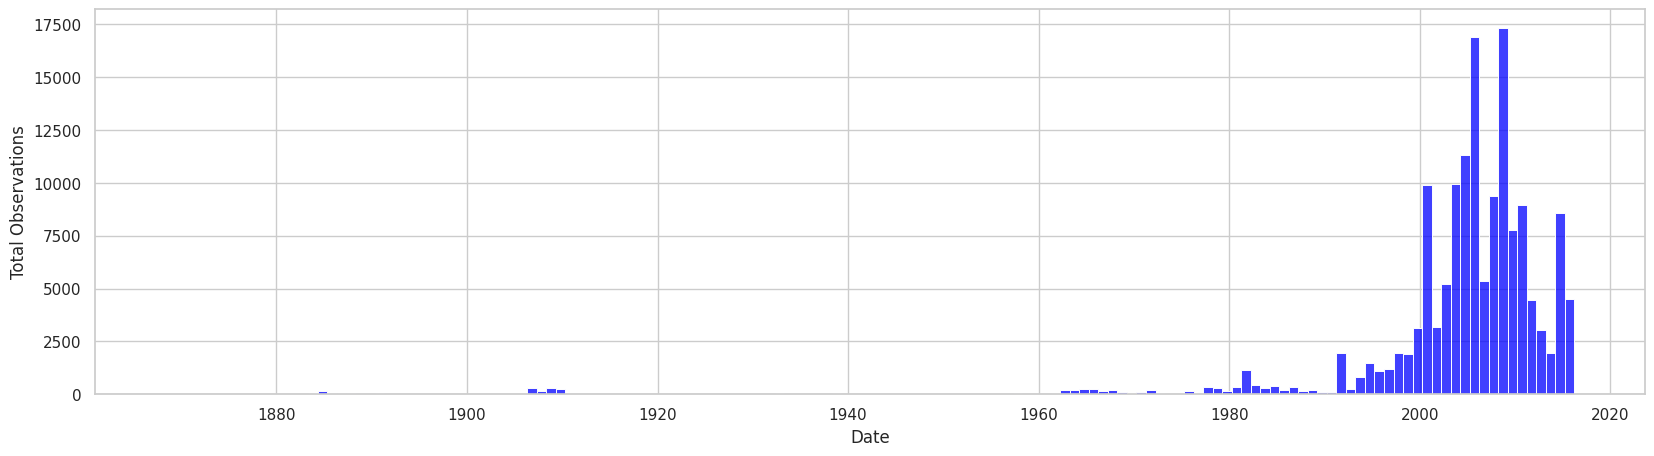

In [56]:
max_year = df['date'].max().year
min_year = df['date'].min().year
bins = max_year - min_year

# histogram of observations over date
plt.figure(figsize=(20, 5))
sns.histplot(data=df, x='date', bins=bins, color='blue')
plt.xlabel('Date')
plt.ylabel('Total Observations')
plt.show()

/home/jack/.local/share/virtualenvs/datadev-5ox7fytP/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jack/.local/share/virtualenvs/datadev-5ox7fytP/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jack/.local/share/virtualenvs/datadev-5ox7fytP/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


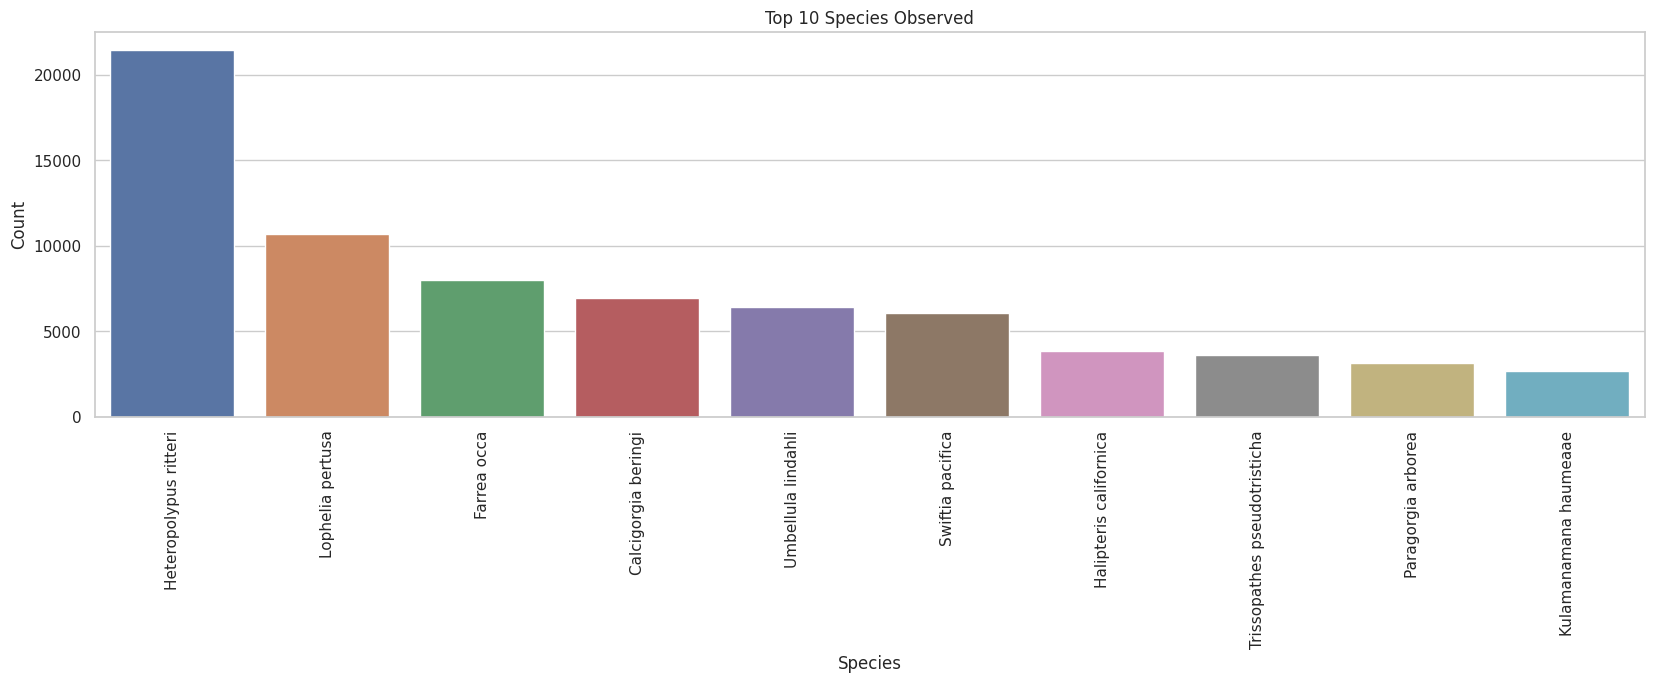

In [61]:
# aggregate by species count
species = df.groupby('sci_name').size().sort_values(ascending=False)

# display species count of top 10 species
plt.figure(figsize=(20, 5))
sns.barplot(x=species[:10].index, y=species[:10].values)
plt.xticks(rotation=90)
plt.title('Top 10 Species Observed')
plt.xlabel('Species')
plt.ylabel('Count')
plt.show()

/tmp/ipykernel_31305/2801557157.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
/home/jack/.local/share/virtualenvs/datadev-5ox7fytP/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jack/.local/share/virtualenvs/datadev-5ox7fytP/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jack/.local/share/virtualenvs/datadev-5ox7fytP/lib/python3.10/site-packa

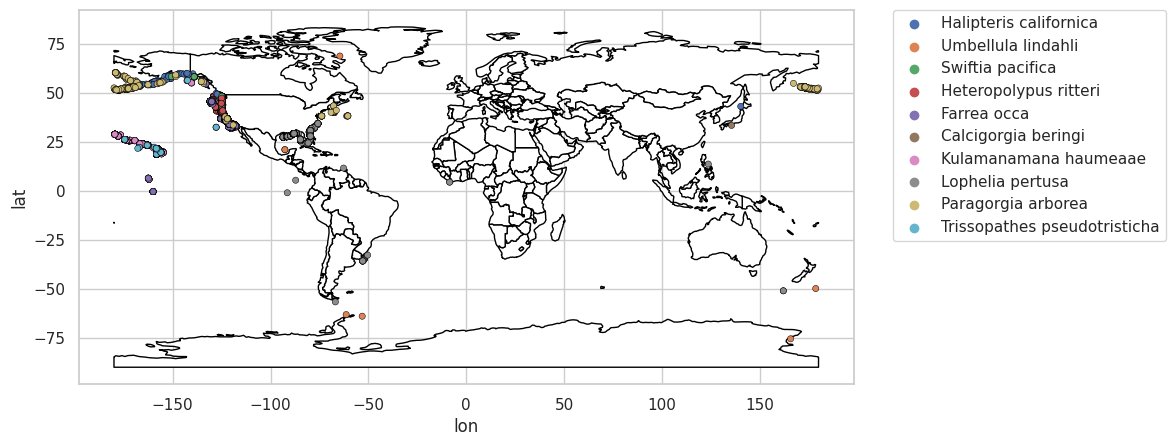

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(ax=ax, color='white', edgecolor='black')

topdf = df[df['sci_name'].isin(species[:10].index)]

sns.scatterplot(
    data=topdf,
    x='lon',
    y='lat',
    hue='sci_name',
    s=20,
    edgecolor='black',
)

# place legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

/tmp/ipykernel_31305/4064027355.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(5, 2, index + 1)


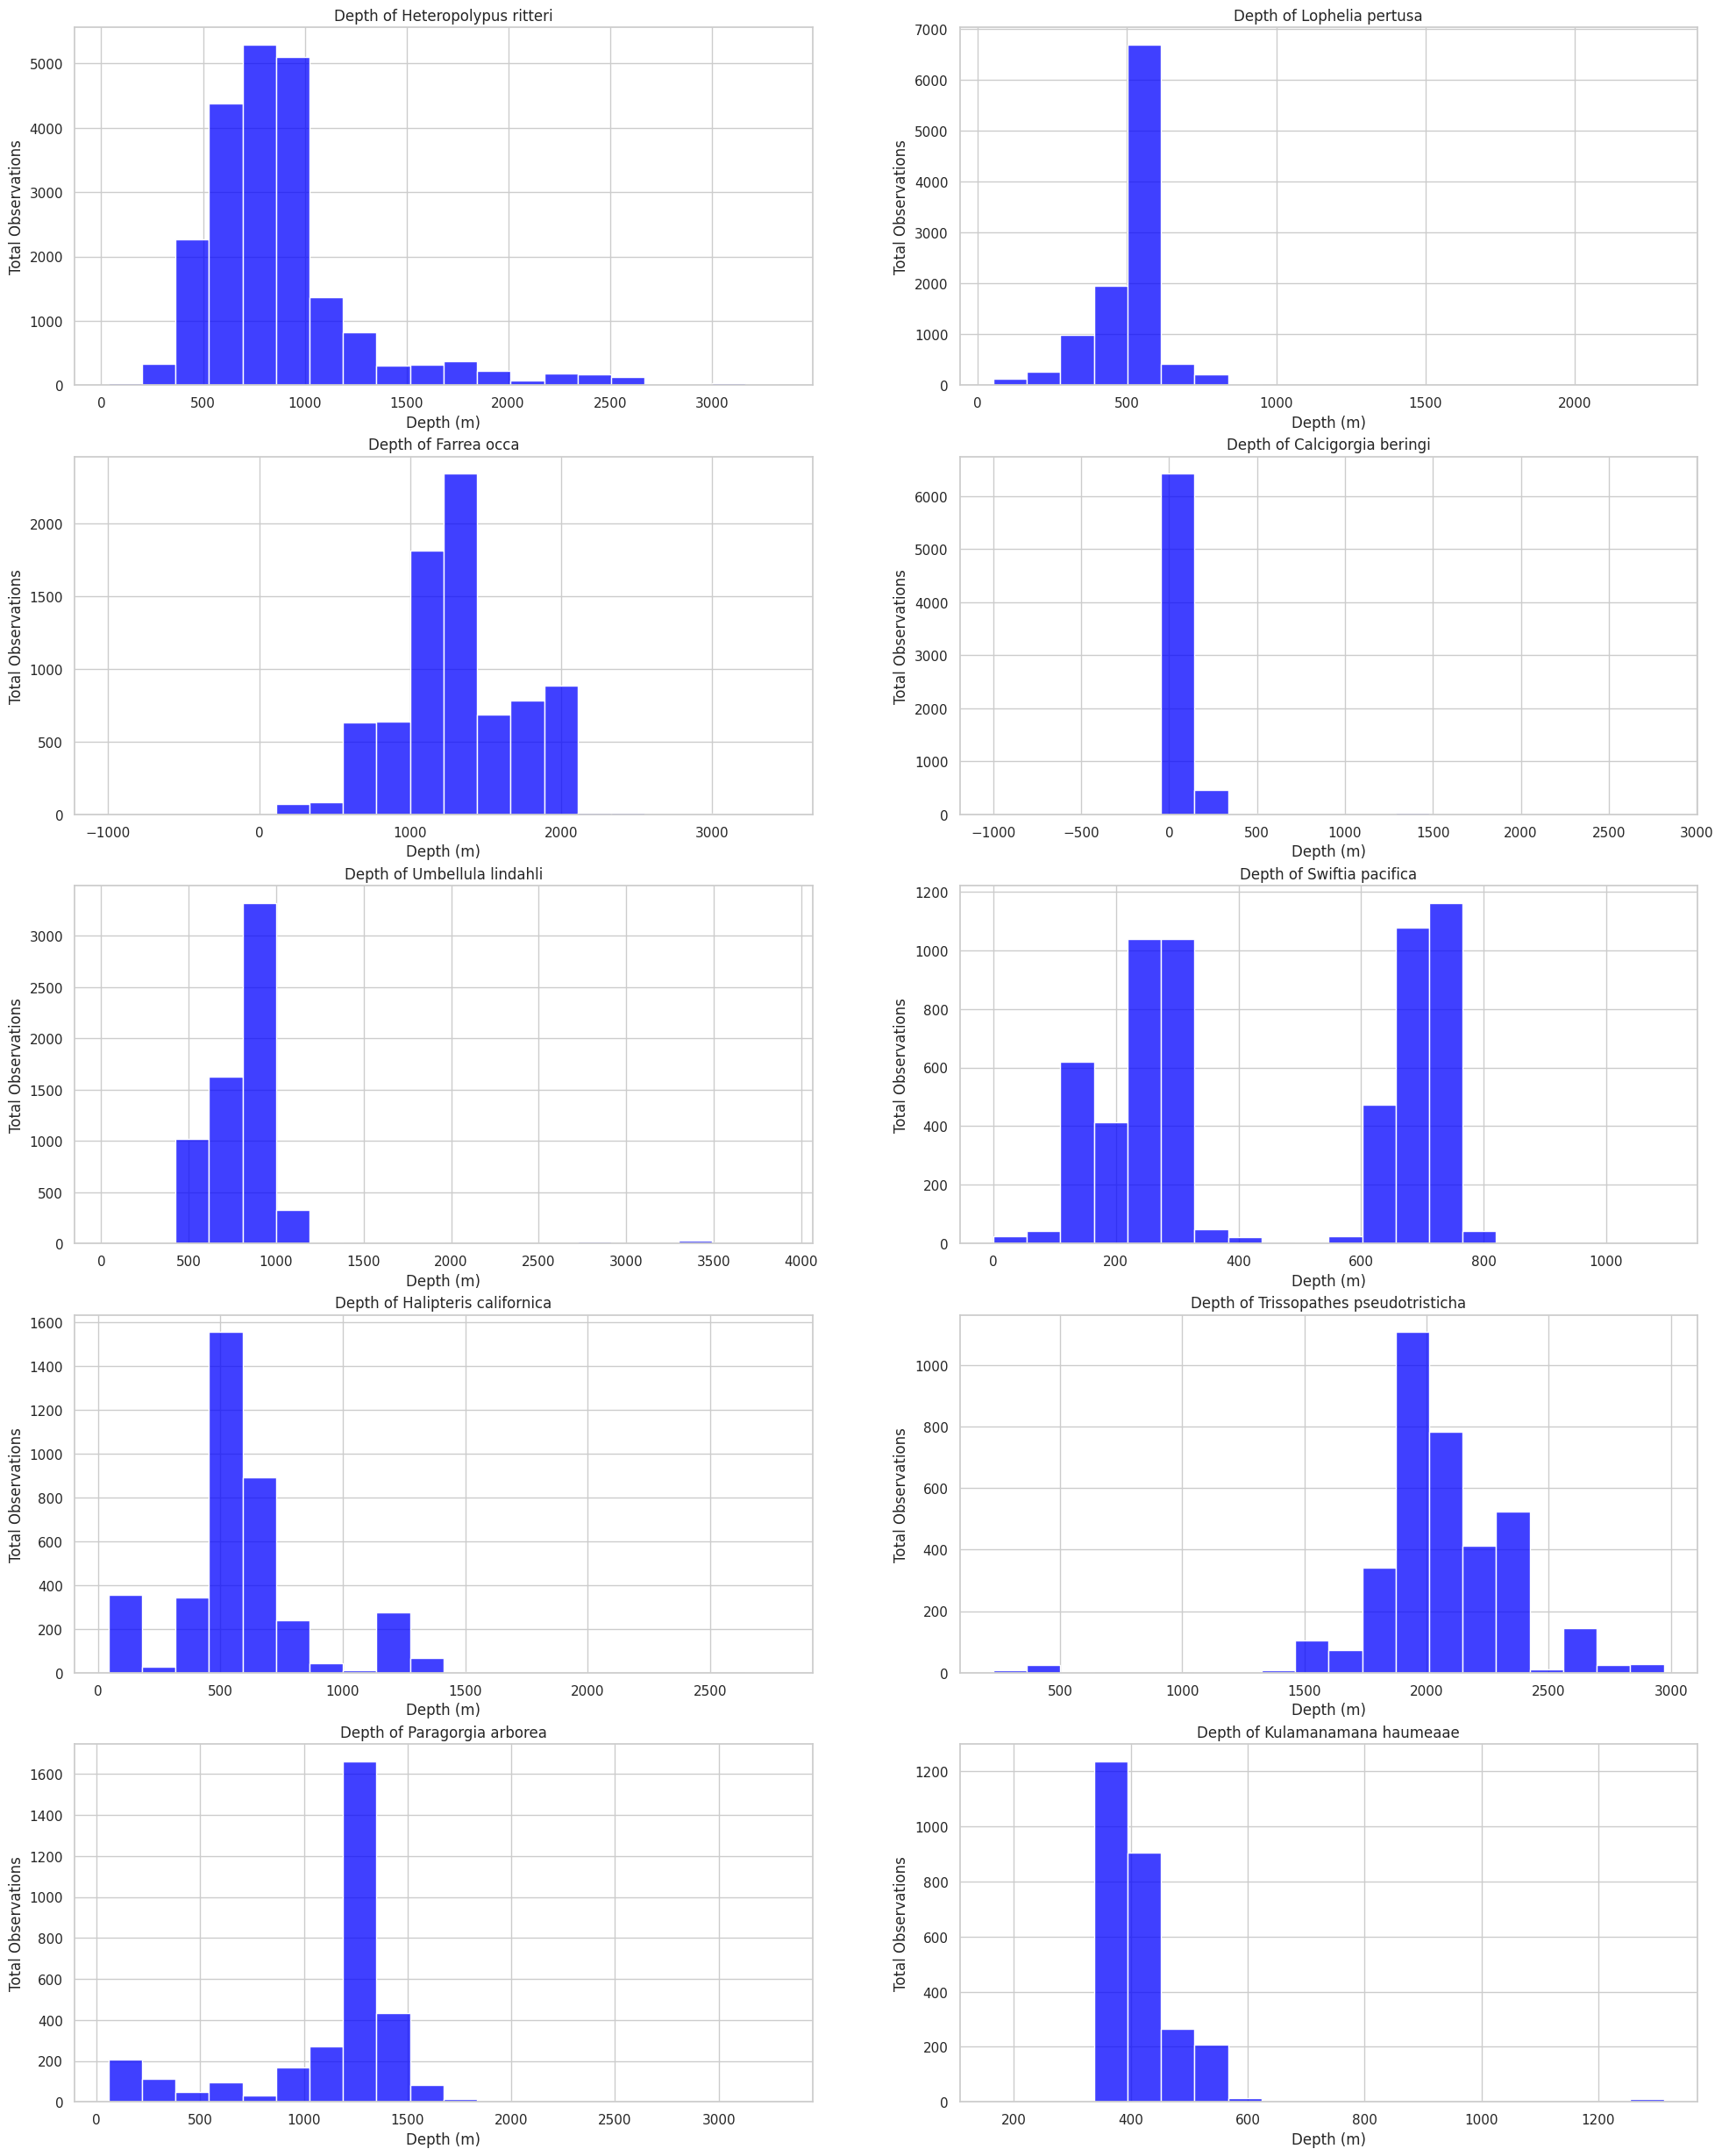

In [69]:
top_species = species[:10].index

topdf = df[df['sci_name'].isin(top_species)]

fig, ax = plt.subplots(figsize=(20, 25))
# tight_layout() automatically adjusts subplot params so that the subplot(s) fits in to the figure area.
fig.tight_layout(pad=3.0)

# plot a histogram of the depth of the top 10 species
for index, spec in enumerate(list(top_species)):
    ax = plt.subplot(5, 2, index + 1)
    sdf = topdf[topdf.sci_name == spec]
    sns.histplot(data=sdf, x='depth_m', bins=20, color='blue')
    plt.xlabel('Depth (m)')
    plt.ylabel('Total Observations')
    plt.title(f'Depth of {spec}. Total Observations: {sdf.shape[0]}')
